In [121]:
import pandas as pd
import numpy as np
import os

RANDOM_STATE = 404

In [122]:
df = pd.read_csv('data/HAD.csv')
df.head()

,AGE,AGE_MISSING,SEX_F,NIHSS_BL,NIHSS_BL_MISSING,SYS_BLOOD_PRESSURE,SYS_BLOOD_PRESSURE_MISSING,PREV_MRS,PREV_MRS_MISSING,ORAL_ANTICOAGULANT,...,ONSET_TO_ADMISSION,ONSET_TO_ADMISSION_MISSING,ONSET_TO_IMAGING,ONSET_TO_IMAGING_MISSING,ONSET_TO_TPA,ONSET_TO_TPA_MISSING,ONSET_TO_GROIN,ONSET_TO_GROIN_MISSING,MRS_90,MRS_90_DICHO
0,70,0,0,3,0,-1,1,0,0,0,...,64,0,96,0,180,0,-1,1,0,0
1,55,0,0,6,0,142,0,3,0,0,...,38,0,104,0,165,0,-1,1,4,1
2,73,0,0,3,0,170,0,0,0,1,...,-1,1,-1,1,-1,1,-1,1,2,0
3,81,0,0,10,0,-1,1,0,0,0,...,69,0,90,0,115,0,-1,1,3,1
4,81,0,1,11,0,-1,1,0,0,0,...,98,0,110,0,120,0,-1,1,0,0


In [123]:
target_feature = 'MRS_90'
y_raw = df.filter([target_feature])
y_raw.to_csv('data/HAD_target.csv', index=False)
df = df.drop(columns=['MRS_90', 'MRS_90_DICHO'], axis=1)

## Data standardization

In [124]:
from dill import load as dill_load

scalerFile = "classifier\scaler.pkl"

with open(scalerFile, "rb") as f:
    scaler = dill_load(f)

df_scaled = scaler.preprocess_clinical_data(np.asarray(df, dtype=float))
X = pd.DataFrame(df_scaled, columns=df.columns)
X

,AGE,AGE_MISSING,SEX_F,NIHSS_BL,NIHSS_BL_MISSING,SYS_BLOOD_PRESSURE,SYS_BLOOD_PRESSURE_MISSING,PREV_MRS,PREV_MRS_MISSING,ORAL_ANTICOAGULANT,...,CTA_CS,CTA_CS_MISSING,ONSET_TO_ADMISSION,ONSET_TO_ADMISSION_MISSING,ONSET_TO_IMAGING,ONSET_TO_IMAGING_MISSING,ONSET_TO_TPA,ONSET_TO_TPA_MISSING,ONSET_TO_GROIN,ONSET_TO_GROIN_MISSING
0,0.509804,0.0,0.0,0.071429,0.0,-1.000,1.0,0.0,0.0,0.0,...,-1.000000,1.0,0.044444,0.0,0.066667,0.0,0.125000,0.0,-1.0000,1.0
1,0.362745,0.0,0.0,0.142857,0.0,0.368,0.0,0.6,0.0,0.0,...,-1.000000,1.0,0.026389,0.0,0.072222,0.0,0.114583,0.0,-1.0000,1.0
2,0.539216,0.0,0.0,0.071429,0.0,0.480,0.0,0.0,0.0,1.0,...,-1.000000,1.0,-1.000000,1.0,-1.000000,1.0,-1.000000,1.0,-1.0000,1.0
3,0.617647,0.0,0.0,0.238095,0.0,-1.000,1.0,0.0,0.0,0.0,...,-1.000000,1.0,0.047917,0.0,0.062500,0.0,0.079861,0.0,-1.0000,1.0
4,0.617647,0.0,1.0,0.261905,0.0,-1.000,1.0,0.0,0.0,0.0,...,-1.000000,1.0,0.068056,0.0,0.076389,0.0,0.083333,0.0,-1.0000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.519608,0.0,0.0,0.071429,0.0,-1.000,1.0,0.0,0.0,0.0,...,-1.000000,1.0,0.124306,0.0,0.134028,0.0,0.159028,0.0,-1.0000,1.0
940,0.441176,0.0,0.0,0.071429,0.0,0.368,0.0,0.6,0.0,0.0,...,-1.000000,1.0,-1.000000,1.0,0.098611,0.0,0.114583,0.0,-1.0000,1.0
941,0.421569,0.0,1.0,0.000000,0.0,0.216,0.0,0.0,0.0,0.0,...,-1.000000,1.0,-1.000000,1.0,-1.000000,1.0,-1.000000,1.0,-1.0000,1.0
942,0.607843,0.0,1.0,0.285714,0.0,-1.000,1.0,0.0,0.0,0.0,...,0.333333,0.0,0.333333,0.0,0.361111,0.0,-1.000000,1.0,0.4375,0.0


In [125]:
# Warning is given while imputing missing values about 'SERUM_GLUCOSE' and 'VALV_HEART' columns due to missing all data in those columns thus they are removed, only to be readded for classification
columns_to_add_back_for_classification = ['SERUM_GLUCOSE', 'SERUM_GLUCOSE_MISSING', 'VALV_HEART']
columns_to_add_back_for_classification_df = X.filter(columns_to_add_back_for_classification)

order_of_columns = list(X.columns)

X = X.drop(columns=columns_to_add_back_for_classification, axis=1)

## Generating missing data based on sklearn imputers

In [126]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer_df = X.copy()  # Creating a copy of the original DataFrame for imputation

# Initialize IterativeImputer with median strategy for missing values
imp = IterativeImputer(missing_values=-1, initial_strategy='mean', random_state=RANDOM_STATE)

# Iterate through columns in the DataFrame
for col in imputer_df.columns:
    # Skip columns ending with '_MISSING'
    if col.endswith('_MISSING'):
        continue
    # Check if there is a corresponding missing flag column
    elif col + "_MISSING" in X.columns:
        # Check if there are missing values to impute
        if (imputer_df[col + "_MISSING"] == 1).any() and (imputer_df[col] == -1).any():
            # Fit imputer on the column and transform the values
            imp.fit(imputer_df[[col]])
            imputer_df[col] = imp.transform(imputer_df[[col]]).ravel()
            imputer_df[col + '_MISSING'] = 0
    else:
        # Check if there are missing values to impute
        if (imputer_df[col] == -1).any():
            # Fit imputer on the column and transform the values
            imp.fit(imputer_df[[col]])
            imputer_df[col] = imp.transform(imputer_df[[col]]).ravel()

# Remove columns related to missingness flags
columns_to_add_back_for_classification_df = pd.concat([columns_to_add_back_for_classification_df, imputer_df.filter(regex='MISSING')], axis=1)
imputer_df = imputer_df[imputer_df.columns.drop(list(imputer_df.filter(regex='MISSING')))]

imputer_df

,AGE,SEX_F,NIHSS_BL,SYS_BLOOD_PRESSURE,PREV_MRS,ORAL_ANTICOAGULANT,HYPERTENSION,HYPERCHOL,ISCH_HEART,SMOKING,...,OCCLUSION_M2,OCCLUSION_ICA,OCCLUSION_ACA,OCCLUSION_PCA,OCCLUSION_VB,CTA_CS,ONSET_TO_ADMISSION,ONSET_TO_IMAGING,ONSET_TO_TPA,ONSET_TO_GROIN
0,0.509804,0.0,0.071429,0.40121,0.0,0.0,1.0,1.0,0.0,1.0,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.480859,0.044444,0.066667,0.125000,0.219827
1,0.362745,0.0,0.142857,0.36800,0.6,0.0,1.0,1.0,0.0,0.0,...,0.217469,0.332149,0.023091,0.055062,0.039076,0.480859,0.026389,0.072222,0.114583,0.219827
2,0.539216,0.0,0.071429,0.48000,0.0,1.0,1.0,1.0,0.0,0.0,...,0.217469,0.332149,0.023091,0.055062,0.039076,0.480859,0.100541,0.119671,0.124461,0.219827
3,0.617647,0.0,0.238095,0.40121,0.0,0.0,1.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.480859,0.047917,0.062500,0.079861,0.219827
4,0.617647,1.0,0.261905,0.40121,0.0,0.0,1.0,1.0,0.0,0.0,...,0.217469,0.332149,0.023091,0.055062,0.039076,0.480859,0.068056,0.076389,0.083333,0.219827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.519608,0.0,0.071429,0.40121,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.480859,0.124306,0.134028,0.159028,0.219827
940,0.441176,0.0,0.071429,0.36800,0.6,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.480859,0.100541,0.098611,0.114583,0.219827
941,0.421569,1.0,0.000000,0.21600,0.0,0.0,1.0,0.0,0.0,0.0,...,0.217469,0.332149,0.023091,0.055062,0.039076,0.480859,0.100541,0.119671,0.124461,0.219827
942,0.607843,1.0,0.285714,0.40121,0.0,0.0,1.0,1.0,0.0,0.0,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.361111,0.124461,0.437500


### Using BIC to get the optimal number of components for GMM

In [127]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def compute_bic(X, n_components_range):
    """
    Computes the Bayesian Information Criterion (BIC) for Gaussian Mixture Models with different numbers of components.
    
    Parameters:
        X (array-like): Input data.
        n_components_range (range): Range of number of components to evaluate.
        
    Returns:
        list: BIC values for each number of components.
    """
    bic = []  # List to store BIC values
    for n_components in n_components_range:
        # Create Gaussian Mixture Model with specified number of components
        gmm = GaussianMixture(n_components=n_components, random_state=RANDOM_STATE)
        gmm.fit(X)
        bic.append(gmm.bic(X))  # Calculate BIC and add to list
    return bic  # Return list of BIC values

optimal_n_components = 7

if optimal_n_components is None:
    n_components_range = range(1, 51)  # Range of number of components to evaluate
    bic_values = compute_bic(imputer_df, n_components_range)  # Compute BIC values
    optimal_n_components = n_components_range[np.argmin(bic_values)]  # Determine optimal number of components

    # Plotting BIC values
    plt.plot(n_components_range, bic_values, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('BIC Value')
    plt.title('BIC for Gaussian Mixture Models')
    plt.grid(True)
    plt.show()


### Gaussian Mixture Model fitting

In [128]:
# Create Gaussian Mixture Model with optimal number of components
gmm = GaussianMixture(n_components=optimal_n_components, random_state=RANDOM_STATE)

# Fit the Gaussian Mixture Model to the imputed DataFrame
gmm.fit(imputer_df)

GaussianMixture(n_components=7, random_state=404)

### *Optional:* Can set all the values of a specific feature to -1 for the purpose of displaying it's distribution on the heatmap below

In [129]:
# Saving the values of a feature to mark them in the heatmap, e.g. CTA_CS
heatmap_feature = None
if heatmap_feature is not None:
    heatmap_feature_original_values = pd.Series(X[heatmap_feature].copy().values, index=X.index)

    # Get maximum and minimum values from the column
    heatmap_feature_max_value = X[heatmap_feature].max()
    heatmap_feature_min_value = X[heatmap_feature].min()

    X[heatmap_feature] = -1
    # Check if the column exists
    if heatmap_feature + '_MISSING' in X.columns:
        X[heatmap_feature + '_MISSING'] = 1

## Generating samples of missing values using conditional GMM

In [130]:
from ConditionalGMM.condGMM import CondGMM
import json

def gmm_generate_samples(n_datapoints=2, n_samples=1000, plot_histograms=False, print_index=False):
    """
    Generate samples using Conditional Gaussian Mixture Model for imputing missing data.

    Args:
        n_datapoints (int/str): Number of data points to consider
        n_samples (int): Number of samples to generate
        plot_histograms (bool): Whether to plot histograms of sampled data
        print_index (bool): Whether to print the index of the current data point
    Returns:
        pd.DataFrame: DataFrame with imputed missing data
    """
    if n_datapoints > X.shape[0]:
        n_datapoints = X.shape[0]

    # Create a copy of the DataFrame for data manipulation
    temp_df = X.head(n_datapoints).copy().astype(object)
    # Remove missing flag columns
    temp_df = temp_df[temp_df.columns.drop(list(temp_df.filter(regex='MISSING')))]
        
    for index, row in X.head(n_datapoints).iterrows():
        # Get indices and values of unknown and known features
        unknown_features_indexes, known_features_indexes, known_features_values = get_feature_indices_and_values(temp_df, index, row)
        
        # If all features are known, continue
        if len(unknown_features_indexes) == 0:
            continue
        
        # Initialize CondGMM
        cGMM = CondGMM(gmm.weights_, gmm.means_, gmm.covariances_, known_features_indexes)
        
        # Generate samples using Conditional GMM
        sampled_data = cGMM.rvs(known_features_values, size=n_samples, random_state=RANDOM_STATE)
        
        # Update unknown features with sampled data
        for feature_index in range(len(unknown_features_indexes)):
            temp_df.iloc[index, unknown_features_indexes[feature_index]] = json.dumps([sampled_data[sample_index][feature_index] for sample_index in range(n_samples)])

        # Plot histograms if specified
        if plot_histograms:
            plot_histogram(temp_df, unknown_features_indexes, index, sampled_data)
        
        # Print index if specified, for debugging purposes
        if print_index:
            print(index)
        
    return temp_df
        
def get_feature_indices_and_values(temp_df, index, row):    
    unknown_features_indexes = []  # Initialize list to store indices of unknown features
    
    # Iterate through columns in the DataFrame
    for col in X.columns:
        # Skip columns ending with '_MISSING'
        if col.endswith('_MISSING'):
            continue
        # Check if there is a corresponding missing flag column
        elif col + "_MISSING" in X.columns:
            # Identify unknown features where missing flag is 1 and value is -1
            if row[col + "_MISSING"] == 1 and (row[col] == -1):
                unknown_features_indexes.append(temp_df.columns.get_loc(col))  # Add index of feature
        else:
            # Identify unknown features where value is -1
            if (row[col] == -1):
                unknown_features_indexes.append(temp_df.columns.get_loc(col))  # Add index of feature
        
    # Find indices of known features
    known_features_indexes = list(set(range(temp_df.shape[1])) - set(unknown_features_indexes))
    
    # Extract values of known features for the given row
    known_features_values = temp_df.iloc[index, known_features_indexes]
    
    return unknown_features_indexes, known_features_indexes, known_features_values  # Return indices and values

def plot_histogram(temp_df, unknown_features_indexes, index, sampled_data, n_bins=20):
    # Create subplots based on the number of unknown features
    fig, axs = plt.subplots(sampled_data.shape[1], 1, figsize=(8, len(unknown_features_indexes) * 4))

    # Plot histograms for each feature
    plot_features(temp_df, sampled_data, axs, unknown_features_indexes, index, n_bins)

    # Add title and labels to the figure
    fig.suptitle(f'Histograms for index {index}', fontsize=20)  # Title with the index
    fig.text(0.5, 0.04, 'Value', ha='center', fontsize=14)  # X-axis label
    fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)  # Y-axis label
    plt.show()  # Show the figure

    
def plot_features(temp_df, sampled_data, axs, unknown_features_indexes, index, n_bins):
    # Ensure axs is a list for consistency in cases when only one feature is plotted
    if not isinstance(axs, np.ndarray):
        axs = [axs]

    for i in range(sampled_data.shape[1]):
        expected_value = imputer_df.iloc[index, unknown_features_indexes[i]]
        
        # Plot histogram for the feature
        axs[i].hist(sampled_data[:, i], bins=n_bins, alpha=0.5, label='sampled data')
        axs[i].hist(imputer_df[imputer_df.columns[unknown_features_indexes[i]]], bins=n_bins, alpha=0.2, label='marginal data')
        axs[i].set_title(f'{temp_df.columns[unknown_features_indexes[i]]}')
        
        # Add expected value as text on the histogram
        axs[i].text(0.95, 0.95, f'Expected value: {expected_value}', ha='right', va='top', transform=axs[i].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
        
        axs[i].legend(loc='upper left')

In [131]:
%load_ext autoreload
%autoreload 2

n_datapoints = X.shape[0]
number_of_samples = 100
cgmm_df = gmm_generate_samples(n_datapoints=n_datapoints, n_samples=number_of_samples)

# Save the imputed DataFrame to a CSV file
cgmm_df.to_csv('data/HAD_after_cgmm.csv', index=False)

cgmm_df.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,AGE,SEX_F,NIHSS_BL,SYS_BLOOD_PRESSURE,PREV_MRS,ORAL_ANTICOAGULANT,HYPERTENSION,HYPERCHOL,ISCH_HEART,SMOKING,...,OCCLUSION_M2,OCCLUSION_ICA,OCCLUSION_ACA,OCCLUSION_PCA,OCCLUSION_VB,CTA_CS,ONSET_TO_ADMISSION,ONSET_TO_IMAGING,ONSET_TO_TPA,ONSET_TO_GROIN
0,0.509804,0.0,0.071429,"[0.3617089382069719, 0.4816417464225087, 0.391...",0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,"[0.4828861061971641, 0.4802052631468126, 0.479...",0.044444,0.066667,0.125,"[0.22144690670191053, 0.22054372115280244, 0.2..."
1,0.362745,0.0,0.142857,0.368,0.6,0.0,1.0,1.0,0.0,0.0,...,"[0.02678683892850775, 0.37342760297902555, 0.7...","[-0.046872459001418926, 0.8500234409390242, -0...","[0.0014545130494818814, -0.0001172483906332758...","[-0.06838245493262692, -0.20132878243821592, -...","[0.025313398337887955, 0.06666004227638853, 0....","[0.48047287432823027, 0.4812799922882814, 0.48...",0.026389,0.072222,0.114583,"[0.22196059875229002, 0.22066610690068805, 0.2..."
2,0.539216,0.0,0.071429,0.48,0.0,1.0,1.0,1.0,0.0,0.0,...,"[0.03099852393357322, 0.1248637289266771, 0.23...","[0.41065383026206415, 0.37044740252240865, 0.3...","[0.028061777775517847, 0.02622959744550661, 0....","[0.06789712247994947, 0.061886769856960844, 0....","[0.04849074198200574, 0.04258655246332041, 0.0...","[0.4833863667218051, 0.4811631300547084, 0.479...","[0.07003014024514399, 0.11747493087016551, 0.0...","[0.09712687910058107, 0.13121498903084106, 0.0...","[0.09850271204928956, 0.12347794798043095, 0.0...","[0.2219605987509646, 0.2191951074247754, 0.219..."
3,0.617647,0.0,0.238095,"[0.49131259988421144, 0.40516485683552017, 0.4...",0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,"[0.47890856831425216, 0.48047310393564324, 0.4...",0.047917,0.0625,0.079861,"[0.21909420793533574, 0.22196059875228993, 0.2..."
4,0.617647,1.0,0.261905,"[0.3875028881722196, 0.41643317961473914, 0.38...",0.0,0.0,1.0,1.0,0.0,0.0,...,"[0.09054277900395172, 0.5516873765481691, 0.17...","[0.348868650671443, 0.37340855439477205, 0.562...","[-0.00017361186158572567, -0.00037376195549851...","[-0.033781390238622325, 0.05102936795318356, -...","[0.08297952155074269, 0.06804881192585013, -0....","[0.47870402432014325, 0.4811579514923018, 0.48...",0.068056,0.076389,0.083333,"[0.22235415169176567, 0.2184760661082099, 0.22..."


### Calculate MSE for generated values

In [132]:
from sklearn.metrics import mean_squared_error

# Create output file
output_file_path = os.path.join("results", "with_missingness.txt")
with open(output_file_path, "a") as f:
    f.write(f"Results for {number_of_samples} samples:\n")

# Initialize dictionary to store MSE and NMSE values for each feature
feature_mse = {}

for index, row in cgmm_df.iterrows():
    # Get the indices and values of unknown features
    unknown_features_indexes = [col_index for col_index, col in enumerate(row) if isinstance(col, str)]
    
    # If all features are known, continue
    if len(unknown_features_indexes) == 0:
        continue
    
    # Compare values of generated samples with imputed values
    for feature_index in range(len(unknown_features_indexes)):
        imputed_value = imputer_df.iloc[index, unknown_features_indexes[feature_index]]
        sampled_value = json.loads(row.iloc[unknown_features_indexes].values[feature_index])
        
        for sample in sampled_value:
            if not pd.isna(sample):
                # Calculate mean squared error
                mse = mean_squared_error(imputed_value.flatten(), np.array(sample).flatten())
                
                # Save each mse and nmse to its corresponding feature in feature_mse and feature_nmse
                if unknown_features_indexes[feature_index] not in feature_mse:
                    feature_mse[unknown_features_indexes[feature_index]] = []
                
                feature_mse[unknown_features_indexes[feature_index]].append(mse)
        
# Print the mean squared error and normalized mean squared error for each feature and save to file
with open(output_file_path, "a") as f:
    for feature_index, mse_list in feature_mse.items():
        mean_mse = np.mean(mse_list)
        f.write(f'Feature {cgmm_df.columns[feature_index]} MSE: {mean_mse}\n')
        print(f'Feature {cgmm_df.columns[feature_index]} MSE: {mean_mse}')
        
with open(output_file_path, "a") as f:
    f.write(f"\n\n")

Feature SYS_BLOOD_PRESSURE MSE: 0.010845268285237557
Feature CTA_CS MSE: 0.021530113254730383
Feature ONSET_TO_GROIN MSE: 0.005814027388351934
Feature OCCLUSION_M1 MSE: 0.08467874173251336
Feature OCCLUSION_M2 MSE: 0.03961044915876957
Feature OCCLUSION_ICA MSE: 0.0531993991836023
Feature OCCLUSION_ACA MSE: 0.0065347382197072194
Feature OCCLUSION_PCA MSE: 0.013648804304831647
Feature OCCLUSION_VB MSE: 0.014184065987479316
Feature ASPECTS MSE: 0.04077206340767902
Feature ONSET_TO_ADMISSION MSE: 0.0029013328882494197
Feature ONSET_TO_IMAGING MSE: 0.0030738629357054174
Feature ONSET_TO_TPA MSE: 0.0003256012698295142
Feature NIHSS_BL MSE: 0.03291175290014788
Feature PREV_MRS MSE: 0.06183622543857886
Feature ORAL_ANTICOAGULANT MSE: 0.05874827094248436
Feature PREV_STROKE MSE: 0.11143928496739995
Feature AF MSE: 0.18367338908203756
Feature DM MSE: 0.28926871091412476
Feature IVT MSE: 0.13899082471208704
Feature HYPERTENSION MSE: 0.47220069969153733
Feature AGE MSE: 0.021381631541167883
Featur

### *Optional:* Generating heatmap which helps visualize how cGMM distributes data

In [133]:
if heatmap_feature is not None:
    # Define bin edges and adjust number of bins
    n_bins = 13
    h_min = heatmap_feature_min_value
    h_max = heatmap_feature_max_value
    width = (h_max - h_min) / (n_bins-1)
    bin_edges = np.arange(h_min - width/2, h_max +  width, width)

    # Save the original values of the heatmap feature
    heatmap_feature_values = cgmm_df[heatmap_feature]

    # Deserializing the values of the heatmap feature
    for i, entry in enumerate(heatmap_feature_values):
        if isinstance(entry, str):
            float_array = json.loads(entry)
            heatmap_feature_values[i] = float_array

    # Determine the number of samples based on the length of an entry with a list of values
    list_length = None
    for entry in heatmap_feature_values:
        if isinstance(entry, list):
            list_length = len(entry)
            break

    histograms = []

    for entry in heatmap_feature_values:
        if isinstance(entry, list):
            # Apply np.histogram with specified bin edges
            hist, _ = np.histogram(entry, bins=bin_edges)
            histograms.append(hist)
        else:
            # Single-value entry: Place it in the correct bin and set frequency to list_length
            hist = np.zeros(len(bin_edges) - 1)
            index = np.digitize([entry], bin_edges)[0] - 1
            if 0 <= index < len(hist):
                hist[index] = list_length
            histograms.append(hist)

    # Reshape histograms to fit imshow format (histograms should be a 2D array)
    histograms_2d = np.array(histograms)

    # Determine figure height based on the number of datapoints
    fig_height = max(6, n_datapoints * 0.2)
    fig_width = min(max(10, bin_edges.shape[0] * 1), 32)

    extent = [bin_edges[0], bin_edges[-1], 0, len(histograms)]

    # Create heatmap
    plt.figure(figsize=(fig_width, fig_height))
    plt.imshow(histograms_2d, aspect='auto', cmap='Reds', extent=extent)
    plt.colorbar()
    plt.xticks(bin_edges, labels=np.round(bin_edges, 2), rotation=90)
    plt.yticks(range(n_datapoints), range(n_datapoints))
    plt.xlabel('Values')
    plt.ylabel('Index')
    plt.title(heatmap_feature + ' values heatmap generated by cGMM')

    # Add markers for original values of a missing feature
    original_values = heatmap_feature_original_values[heatmap_feature_original_values != -1] # Selecting only the non -1 values
    indexes = heatmap_feature_original_values.index[heatmap_feature_original_values != -1] + 0.5 # Indexes corresponding to non -1 values
    plt.scatter(original_values, indexes, color='red', marker='o', s=80, label='Original Values')
    plt.scatter(imputer_df[heatmap_feature], imputer_df.index + 0.5, color='blue', marker='x', label='Imputer Values')

    plt.grid(True)
    plt.legend()
    plt.savefig('images/heatmaps/' + heatmap_feature + '_heatmap.png')
    plt.show()

## cGMM classification

In [134]:
from dill import load as dill_load
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

classifier = load_model('classifier\model.h5', compile = False)
scalerFile = "classifier\scaler.pkl"

with open(scalerFile, "rb") as f:
    scaler = dill_load(f)

# X_after_cgmm = pd.read_csv('data\HAD_after_cgmm.csv', sep = ',')
X_after_cgmm = pd.concat([cgmm_df, columns_to_add_back_for_classification_df], axis=1)
X_after_cgmm = X_after_cgmm[order_of_columns]
y = LabelEncoder().fit_transform(y_raw.values.ravel())

# Deserializing the samples generated by cGMM
for col in X_after_cgmm.columns:
    X_after_cgmm[col] = X_after_cgmm[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

X_after_cgmm

,AGE,AGE_MISSING,SEX_F,NIHSS_BL,NIHSS_BL_MISSING,SYS_BLOOD_PRESSURE,SYS_BLOOD_PRESSURE_MISSING,PREV_MRS,PREV_MRS_MISSING,ORAL_ANTICOAGULANT,...,CTA_CS,CTA_CS_MISSING,ONSET_TO_ADMISSION,ONSET_TO_ADMISSION_MISSING,ONSET_TO_IMAGING,ONSET_TO_IMAGING_MISSING,ONSET_TO_TPA,ONSET_TO_TPA_MISSING,ONSET_TO_GROIN,ONSET_TO_GROIN_MISSING
0,0.509804,0,0.0,0.071429,0,"[0.3617089382069719, 0.4816417464225087, 0.391...",0,0.0,0,0.0,...,"[0.4828861061971641, 0.4802052631468126, 0.479...",0,0.044444,0,0.066667,0,0.125,0,"[0.22144690670191053, 0.22054372115280244, 0.2...",0
1,0.362745,0,0.0,0.142857,0,0.368,0,0.6,0,0.0,...,"[0.48047287432823027, 0.4812799922882814, 0.48...",0,0.026389,0,0.072222,0,0.114583,0,"[0.22196059875229002, 0.22066610690068805, 0.2...",0
2,0.539216,0,0.0,0.071429,0,0.48,0,0.0,0,1.0,...,"[0.4833863667218051, 0.4811631300547084, 0.479...",0,"[0.07003014024514399, 0.11747493087016551, 0.0...",0,"[0.09712687910058107, 0.13121498903084106, 0.0...",0,"[0.09850271204928956, 0.12347794798043095, 0.0...",0,"[0.2219605987509646, 0.2191951074247754, 0.219...",0
3,0.617647,0,0.0,0.238095,0,"[0.49131259988421144, 0.40516485683552017, 0.4...",0,0.0,0,0.0,...,"[0.47890856831425216, 0.48047310393564324, 0.4...",0,0.047917,0,0.0625,0,0.079861,0,"[0.21909420793533574, 0.22196059875228993, 0.2...",0
4,0.617647,0,1.0,0.261905,0,"[0.3875028881722196, 0.41643317961473914, 0.38...",0,0.0,0,0.0,...,"[0.47870402432014325, 0.4811579514923018, 0.48...",0,0.068056,0,0.076389,0,0.083333,0,"[0.22235415169176567, 0.2184760661082099, 0.22...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.519608,0,0.0,0.071429,0,"[0.3631210424133236, 0.42125795157403123, 0.37...",0,0.0,0,0.0,...,"[0.48260000869759395, 0.4800882983885713, 0.47...",0,0.124306,0,0.134028,0,0.159028,0,"[0.2217624812277154, 0.22042456379024658, 0.22...",0
940,0.441176,0,0.0,0.071429,0,0.368,0,0.6,0,0.0,...,"[0.4791120427477416, 0.48163104538106594, 0.48...",0,"[0.07486895384356015, 0.09105433574757882, 0.0...",0,0.098611,0,0.114583,0,"[0.2217624812277155, 0.22042456379024666, 0.22...",0
941,0.421569,0,1.0,0.0,0,0.216,0,0.0,0,0.0,...,"[0.4833863667218051, 0.4811631300547084, 0.479...",0,"[0.06461285340485669, 0.11205764402987821, 0.0...",0,"[0.09439857175375066, 0.12848668168401065, 0.0...",0,"[0.09958789879287104, 0.12456313472401243, 0.0...",0,"[0.2219605987509646, 0.2191951074247754, 0.219...",0
942,0.607843,0,1.0,0.285714,0,"[0.3787802944800593, 0.35223282301282904, 0.37...",0,0.0,0,0.0,...,0.333333,0,0.333333,0,0.361111,0,"[0.1215793031471406, 0.122983139065537, 0.1250...",0,0.4375,0


In [135]:
from sklearn.model_selection import train_test_split

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_after_cgmm, y, test_size=0.2, random_state=RANDOM_STATE)

# Initialize an empty dictionary to store results
cgmm_classification_results = {}

for row_index, row in X_test.iterrows():
    serialized_arrays = []
    non_serialized_values = []
    
    # Separate serialized arrays from non-serialized values
    for col, value in row.items():
        if isinstance(value, list):
            serialized_arrays.append((col, serialized_array))
        else:
            non_serialized_values.append((col, value))

    # Initialize an empty list to store results for this row
    row_results = []
    
    # Iterate over each index of serialized arrays
    for i in range(number_of_samples):
        # Initialize a combined row with non-serialized values
        combined_row = non_serialized_values.copy()
        
        # Append the entry at index i of each serialized array to the combined row
        for col, serialized_array in serialized_arrays:
            if i < len(serialized_array):
                combined_row.append((col, serialized_array[i]))
        
        # Convert combined_row to an array
        combined_row_array = [value for _, value in combined_row]
        
        # Run the combined row through the classifier
        result_array = classifier.predict([combined_row_array], verbose=0)
        
        row_results.append(result_array)
        
    # Store the results for this row in the dictionary
    cgmm_classification_results[row_index] = row_results

In [136]:
# Initialize an empty dictionary to store column averages for each entry
cgmm_column_averages = []

# Iterate over each entry in the dictionary
for key, value in cgmm_classification_results.items():
    
    # Calculate the average of each column
    column_averages = np.mean(value, axis=0)
    
    # Store the column averages for this entry in the dictionary
    cgmm_column_averages.append(column_averages)

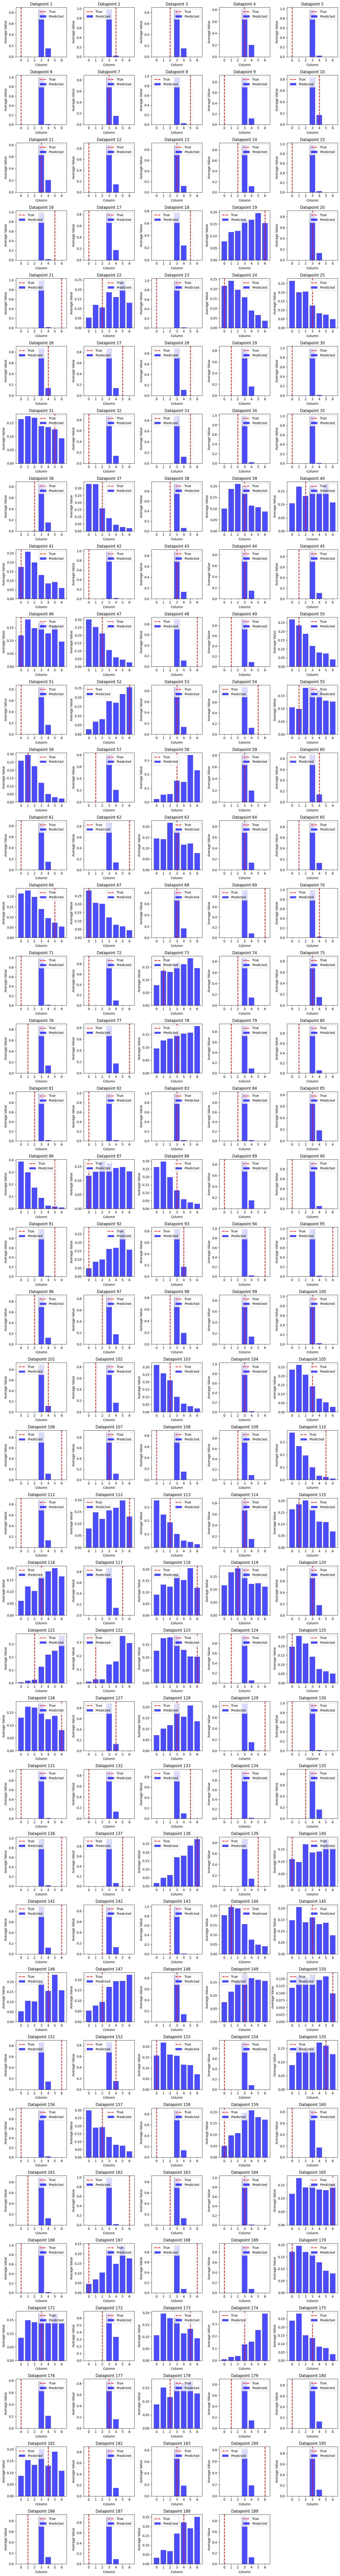

In [138]:
# Set the number of entries to visualize
num_datapoints = len(cgmm_column_averages)

# Set the figure size based on the number of entries
plt.figure(figsize=(15, 3 * num_datapoints // 5))

for i, column_averages in enumerate(cgmm_column_averages):
    # Generate a list of class labels based on the number of columns in the array
    class_labels = np.arange(len(column_averages[0]))

    # Ensure class_labels is a numpy array
    class_labels = np.array(class_labels)

    # Plot a bar chart for the current entry
    plt.subplot(num_datapoints // 5 + 1, 5, i + 1)
    plt.bar(class_labels, column_averages[0], color='blue', alpha=0.7, label='Predicted')
    
    # Superimpose the actual true value
    true_value = y[i]
    plt.axvline(x=true_value, color='red', linestyle='--', linewidth=2, label='True')
    
    plt.xlabel('Column')
    plt.ylabel('Average Value')
    plt.title(f'Datapoint {i+1}')
    plt.xticks(class_labels)
    plt.legend()

plt.tight_layout()
plt.savefig('images\classification\HAD_after_cgmm.png')
plt.show()